<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/More_Cross_Resonance_Plots_in_Colab_with_QuTiP_CuPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2026)

Open Access (CC-BY-4.0)

In [1]:
"""
Cross-resonance (CR) entanglement demo using QuTiP for operators/visualization and
CuPy for GPU-accelerated evolution (when available).

The workflow is intentionally staged:
  1) 1D visualization: entanglement (concurrence/entropy) vs time + population heatmap.
  2) 3D visualization: a spin-Wigner (qudit) sphere plot for the evolved 4D state.

This notebook prioritizes correctness and reproducibility over micro-optimizations.
"""

from __future__ import annotations

from dataclasses import dataclass


@dataclass(frozen=True)
class ControlKnobs:
    """Configuration parameters for the CR simulation and plotting."""

    # Compute / runtime
    prefer_gpu: bool = True
    complex_dtype: str = "complex128"  # Use "complex64" for speed on some GPUs.
    verbose_runtime_report: bool = True

    # Effective CR Hamiltonian parameters (MHz)
    # Following the common effective model where:
    #   H = (Ω_ZX/2) ZX + (Ω_ZZ/4) ZZ + (Ω_IX/2) IX
    # and the target ZX_{π/2} gate corresponds to exp(-i * π/4 * ZX).
    omega_zx_mhz: float = 5.0
    omega_zz_mhz: float = 0.0
    omega_ix_mhz: float = 0.0

    # Simulation time grid
    num_time_points: int = 801
    t_max_gate_multiples: float = 2.0  # Simulate up to this multiple of t_gate.

    # Wigner visualization resolution
    wigner_theta_points: int = 101
    wigner_phi_points: int = 201

    # Plotting
    figure_dpi: int = 200
    colormap_name: str = "viridis"


KNOBS = ControlKnobs()


In [2]:
from __future__ import annotations

import re
import subprocess
import sys
from typing import Optional


def _run(cmd: str) -> str:
    """Run a bash command and return stdout (raises on failure)."""
    completed = subprocess.run(
        ["bash", "-lc", cmd],
        check=False,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
    )
    if completed.returncode != 0:
        raise RuntimeError(
            f"Command failed (exit {completed.returncode}): {cmd}\n{completed.stdout}"
        )
    return completed.stdout


def _detect_gpu_name() -> Optional[str]:
    """Return GPU name via nvidia-smi, or None if unavailable."""
    try:
        out = _run("nvidia-smi --query-gpu=name --format=csv,noheader")
        name = out.strip()
        return name if name else None
    except Exception:
        return None


def _detect_cuda_major() -> Optional[int]:
    """Detect CUDA major version (best-effort) from nvcc or version files."""
    # Attempt 1: nvcc --version
    try:
        out = _run("nvcc --version")
        match = re.search(r"release\s+(\d+)\.", out)
        if match:
            return int(match.group(1))
    except Exception:
        pass

    # Attempt 2: /usr/local/cuda/version.json (common in Colab)
    try:
        out = _run("cat /usr/local/cuda/version.json")
        match = re.search(r"\"cuda\".*\"(\d+)\.", out)
        if match:
            return int(match.group(1))
    except Exception:
        pass

    return None


gpu_name = _detect_gpu_name()
cuda_major = _detect_cuda_major()

print(f"Detected GPU name: {gpu_name}")
print(f"Detected CUDA major version: {cuda_major}")

# Install QuTiP and scientific stack.
_run(f"{sys.executable} -m pip install --upgrade pip")
_run(f"{sys.executable} -m pip install qutip numpy scipy matplotlib")

# Install CuPy only if we have a CUDA GPU and we prefer GPU.
if KNOBS.prefer_gpu and gpu_name and cuda_major:
    if cuda_major == 11:
        cupy_pkg = "cupy-cuda11x"
    elif cuda_major == 12:
        cupy_pkg = "cupy-cuda12x"
    elif cuda_major == 13:
        cupy_pkg = "cupy-cuda13x"
    else:
        # Conservative fallback: try CUDA 12 wheel first.
        cupy_pkg = "cupy-cuda12x"

    print(f"Installing CuPy wheel package: {cupy_pkg}")
    _run(f"{sys.executable} -m pip install {cupy_pkg}")
else:
    print("Skipping CuPy install (no CUDA GPU detected or prefer_gpu=False).")


Detected GPU name: NVIDIA L4
Detected CUDA major version: 12
Installing CuPy wheel package: cupy-cuda12x


In [3]:
from __future__ import annotations

import math
from typing import Any, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt

# Matplotlib defaults (200 DPI requested).
mpl.rcParams.update(
    {
        "figure.dpi": KNOBS.figure_dpi,
        "savefig.dpi": KNOBS.figure_dpi,
        "image.cmap": KNOBS.colormap_name,
    }
)

# Optional CuPy import.
try:
    import cupy as cp  # type: ignore

    _cupy_available = True
except Exception:
    cp = None  # type: ignore
    _cupy_available = False


def _gpu_is_usable() -> bool:
    """Return True if CuPy is importable and sees at least one CUDA device."""
    if not _cupy_available or cp is None:
        return False
    try:
        return cp.cuda.runtime.getDeviceCount() > 0
    except Exception:
        return False


GPU_USABLE = KNOBS.prefer_gpu and _gpu_is_usable()
XP = cp if GPU_USABLE else np  # "xp" convention: array API namespace.

DTYPE = np.complex128 if KNOBS.complex_dtype == "complex128" else np.complex64

if KNOBS.verbose_runtime_report:
    print(f"QuTiP version: {qt.__version__}")
    print(f"NumPy version: {np.__version__}")
    if GPU_USABLE and cp is not None:
        dev = cp.cuda.runtime.getDevice()
        props = cp.cuda.runtime.getDeviceProperties(dev)
        print("CuPy is enabled.")
        print(f"CUDA device index: {dev}")
        print(f"CUDA device name: {props.get('name', b'').decode('utf-8', 'ignore')}")
        print(f"Using dtype: {DTYPE}")
    else:
        print("CuPy GPU path is not enabled; running on CPU.")
        print(f"Using dtype: {DTYPE}")


def to_numpy(arr: Any) -> np.ndarray:
    """Convert an array-like (NumPy or CuPy) into a NumPy ndarray."""
    if cp is not None and _cupy_available and isinstance(arr, cp.ndarray):  # type: ignore
        return cp.asnumpy(arr)  # type: ignore
    return np.asarray(arr)


QuTiP version: 5.2.2
NumPy version: 2.0.2
CuPy is enabled.
CUDA device index: 0
CUDA device name: NVIDIA L4
Using dtype: <class 'numpy.complex128'>


In [4]:
from __future__ import annotations

from dataclasses import asdict


def mhz_to_rad_s(freq_mhz: float) -> float:
    """Convert MHz to angular frequency (rad/s)."""
    return 2.0 * math.pi * 1.0e6 * freq_mhz


def build_effective_cr_hamiltonian(
    omega_zx_mhz: float,
    omega_zz_mhz: float,
    omega_ix_mhz: float,
) -> qt.Qobj:
    """
    Build an effective cross-resonance Hamiltonian on two qubits.

    Model:
      H = (Ω_ZX/2) * (Z ⊗ X) + (Ω_ZZ/4) * (Z ⊗ Z) + (Ω_IX/2) * (I ⊗ X)

    Args:
        omega_zx_mhz: ZX interaction strength in MHz.
        omega_zz_mhz: Residual ZZ interaction strength in MHz.
        omega_ix_mhz: Undesired IX term strength in MHz.

    Returns:
        QuTiP Qobj Hamiltonian with dims [[2, 2], [2, 2]].
    """
    sx = qt.sigmax()
    sz = qt.sigmaz()
    ident = qt.qeye(2)

    zx = qt.tensor(sz, sx)
    zz = qt.tensor(sz, sz)
    ix = qt.tensor(ident, sx)

    omega_zx = mhz_to_rad_s(omega_zx_mhz)
    omega_zz = mhz_to_rad_s(omega_zz_mhz)
    omega_ix = mhz_to_rad_s(omega_ix_mhz)

    h = (omega_zx / 2.0) * zx + (omega_zz / 4.0) * zz + (omega_ix / 2.0) * ix
    return h


H_EFF = build_effective_cr_hamiltonian(
    omega_zx_mhz=KNOBS.omega_zx_mhz,
    omega_zz_mhz=KNOBS.omega_zz_mhz,
    omega_ix_mhz=KNOBS.omega_ix_mhz,
)

# Initial state: |+0> to make the ZX term generate entanglement clearly.
ket0 = qt.basis(2, 0)
ket1 = qt.basis(2, 1)
ket_plus = (ket0 + ket1).unit()
PSI0 = qt.tensor(ket_plus, ket0)

omega_zx_rad_s = mhz_to_rad_s(KNOBS.omega_zx_mhz)
t_gate = math.pi / (2.0 * omega_zx_rad_s)  # time for exp(-i * pi/4 * ZX) when IX=ZZ=0
t_max = KNOBS.t_max_gate_multiples * t_gate
tlist = np.linspace(0.0, t_max, KNOBS.num_time_points)

print("Control knobs:")
for k, v in asdict(KNOBS).items():
    print(f"  {k}: {v}")

print(f"\nDerived ZX_pi/2 gate time (seconds): {t_gate}")
print(f"Simulating up to t_max (seconds): {t_max}")


Control knobs:
  prefer_gpu: True
  complex_dtype: complex128
  verbose_runtime_report: True
  omega_zx_mhz: 5.0
  omega_zz_mhz: 0.0
  omega_ix_mhz: 0.0
  num_time_points: 801
  t_max_gate_multiples: 2.0
  wigner_theta_points: 101
  wigner_phi_points: 201
  figure_dpi: 200
  colormap_name: viridis

Derived ZX_pi/2 gate time (seconds): 5.0000000000000004e-08
Simulating up to t_max (seconds): 1.0000000000000001e-07


In [5]:
from __future__ import annotations

from typing import Dict


def evolve_state_gpu_diagonalization(
    h_eff: qt.Qobj,
    psi0: qt.Qobj,
    times: np.ndarray,
) -> Dict[str, np.ndarray]:
    """
    Evolve a two-qubit state under a time-independent Hamiltonian.

    This method diagonalizes H once (on GPU if available) and evaluates:
      |psi(t)> = V * exp(-i * diag(evals) * t) * V^† |psi(0)>

    Args:
        h_eff: Hamiltonian Qobj (4x4 for two qubits).
        psi0: Initial state ket Qobj (4x1).
        times: Time points (seconds), NumPy array.

    Returns:
        Dictionary with NumPy arrays:
          - "times_s"
          - "state_amplitudes": shape (4, T)
          - "populations": shape (4, T)
          - "concurrence": shape (T,)
          - "entanglement_entropy_bits": shape (T,)
    """
    h_np = h_eff.full().astype(DTYPE, copy=False)
    psi_np = psi0.full().astype(DTYPE, copy=False).reshape((4,))

    h_xp = XP.asarray(h_np)
    psi_xp = XP.asarray(psi_np)
    t_xp = XP.asarray(times, dtype=float)

    # Hermitian eigendecomposition.
    evals, evecs = XP.linalg.eigh(h_xp)

    # Project initial state into eigenbasis.
    coeff0 = evecs.conj().T @ psi_xp  # shape (4,)

    # Vectorized phases: shape (4, T)
    phases = XP.exp((-1j) * evals[:, None] * t_xp[None, :])

    # Reconstruct state amplitudes in computational basis: shape (4, T)
    psi_t = evecs @ (coeff0[:, None] * phases)

    # Populations in computational basis.
    populations = XP.abs(psi_t) ** 2

    # Concurrence for pure two-qubit state.
    a00 = psi_t[0, :]
    a01 = psi_t[1, :]
    a10 = psi_t[2, :]
    a11 = psi_t[3, :]
    concurrence = 2.0 * XP.abs(a00 * a11 - a01 * a10)

    # Entanglement entropy (bits) via reduced eigenvalues.
    # Clip small negative due to floating error.
    one_minus_c2 = XP.clip(1.0 - concurrence**2, 0.0, 1.0)
    delta = XP.sqrt(one_minus_c2)
    lam_plus = 0.5 * (1.0 + delta)
    lam_minus = 0.5 * (1.0 - delta)

    eps = 1e-15
    log2 = XP.log(2.0)
    entropy = -(
        lam_plus * (XP.log(lam_plus + eps) / log2)
        + lam_minus * (XP.log(lam_minus + eps) / log2)
    )

    return {
        "times_s": times,
        "state_amplitudes": to_numpy(psi_t),
        "populations": to_numpy(populations),
        "concurrence": to_numpy(concurrence),
        "entanglement_entropy_bits": to_numpy(entropy),
    }


results = evolve_state_gpu_diagonalization(H_EFF, PSI0, tlist)

times_s = results["times_s"]
times_ns = 1.0e9 * times_s
amps = results["state_amplitudes"]
pops = results["populations"]
conc = results["concurrence"]
entropy_bits = results["entanglement_entropy_bits"]

t_star_idx = int(np.argmax(conc))
t_star_s = float(times_s[t_star_idx])
t_star_ns = float(times_ns[t_star_idx])
c_star = float(conc[t_star_idx])

print(f"Max concurrence: {c_star}")
print(f"Time of max concurrence (ns): {t_star_ns}")
print(f"State amplitudes at max concurrence (a00,a01,a10,a11):\n{amps[:, t_star_idx]}")


Max concurrence: 0.9999999999999998
Time of max concurrence (ns): 50.00000000000001
State amplitudes at max concurrence (a00,a01,a10,a11):
[ 5.00000000e-01+3.11164266e-19j -5.07326818e-18-5.00000000e-01j
  5.00000000e-01+3.11164266e-19j  5.07326818e-18+5.00000000e-01j]


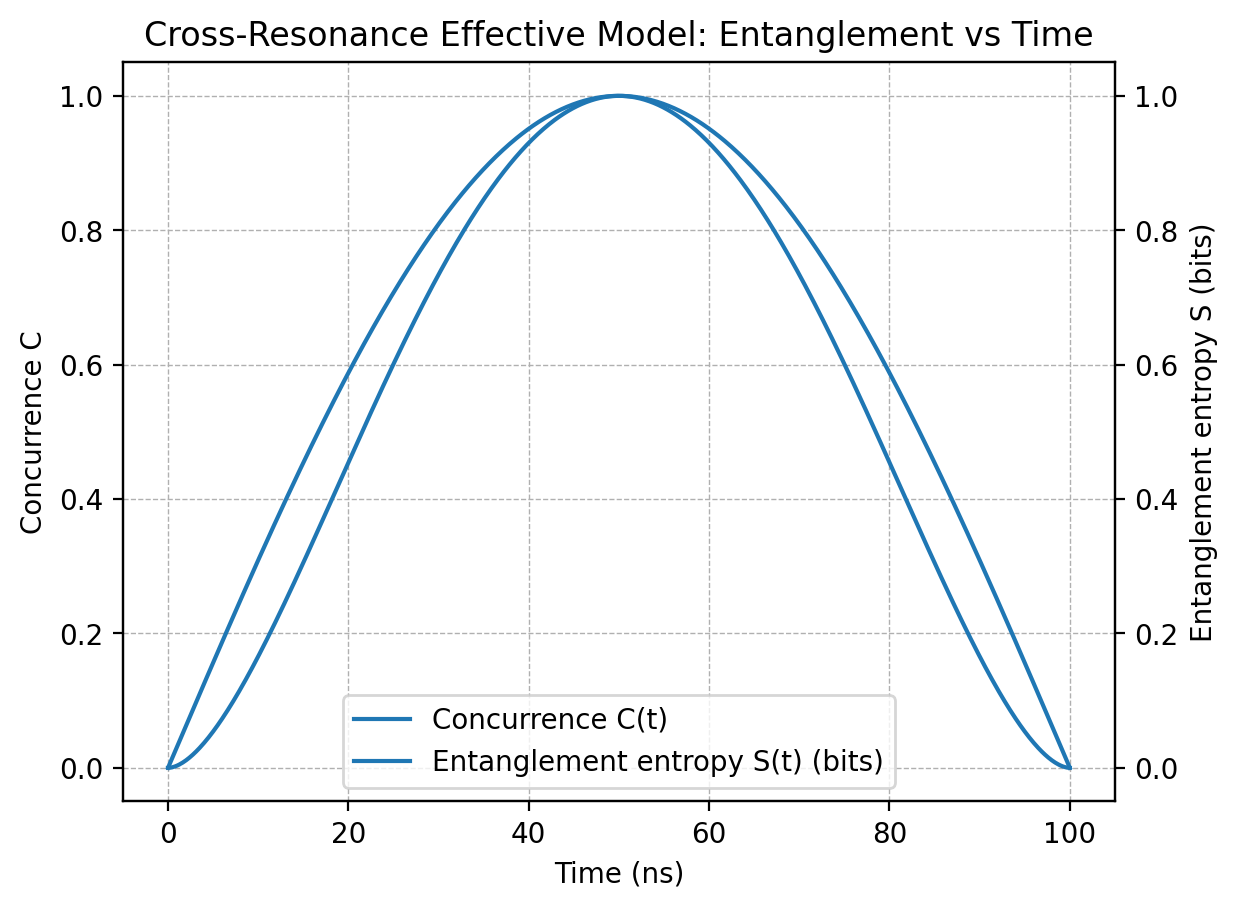

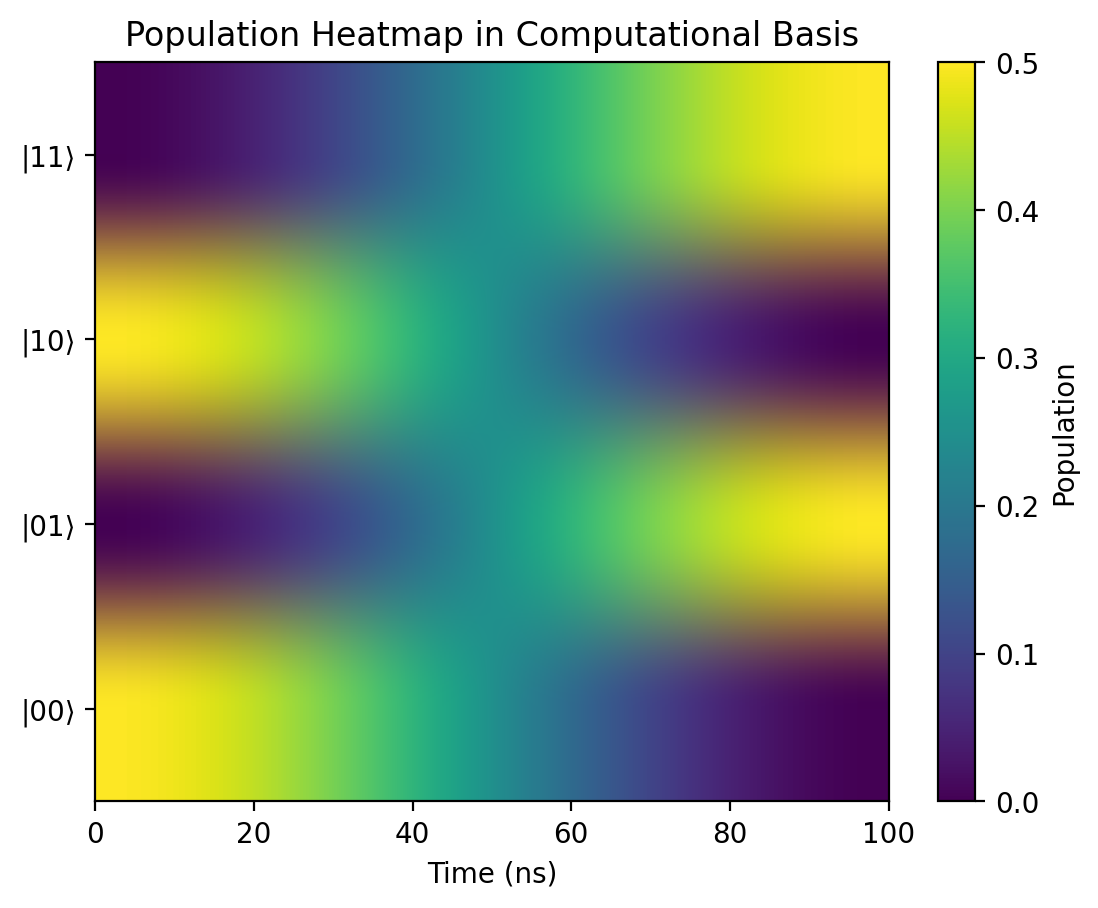

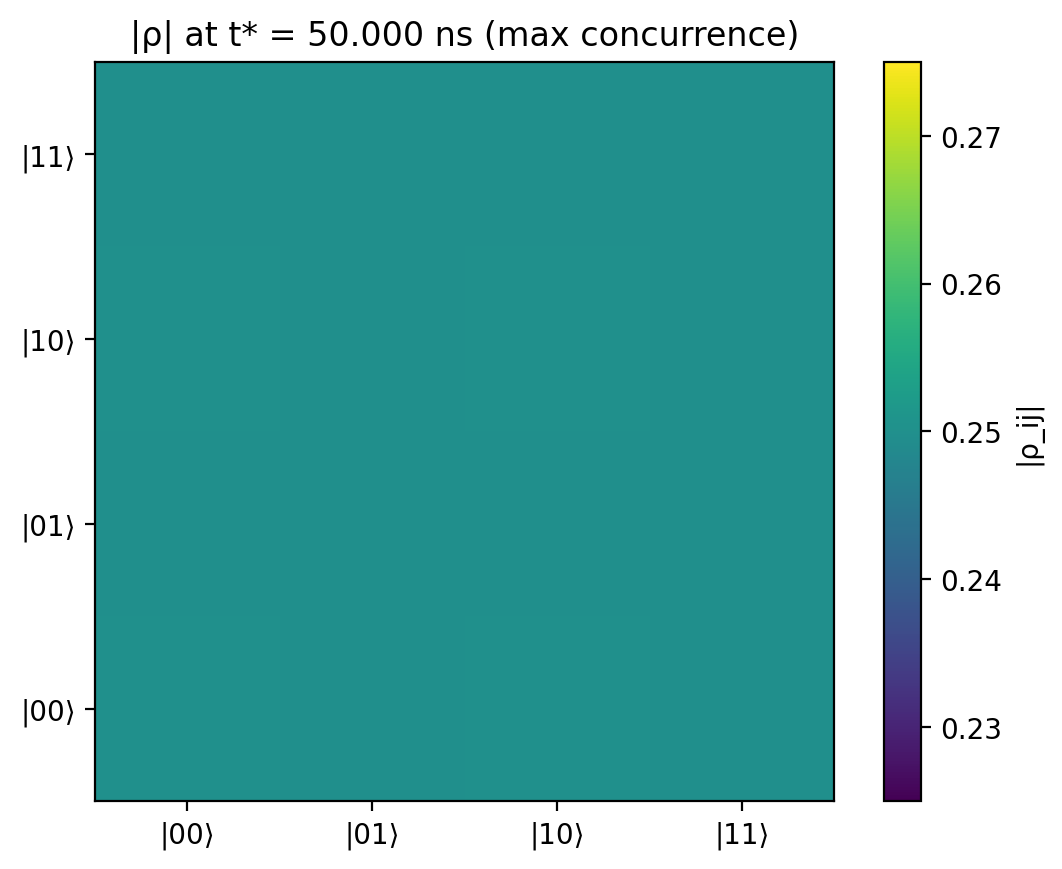

In [6]:
from __future__ import annotations

basis_labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]

# 1D plot: concurrence and entropy vs time.
fig, ax1 = plt.subplots()
ax1.plot(times_ns, conc, label="Concurrence C(t)")
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Concurrence C")
ax1.set_title("Cross-Resonance Effective Model: Entanglement vs Time")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

ax2 = ax1.twinx()
ax2.plot(times_ns, entropy_bits, label="Entanglement entropy S(t) (bits)")
ax2.set_ylabel("Entanglement entropy S (bits)")

# Combine legends.
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.show()

# Heatmap: populations vs time (scientific gradient + colorbar).
fig, ax = plt.subplots()
im = ax.imshow(
    pops,
    aspect="auto",
    origin="lower",
    extent=[times_ns[0], times_ns[-1], -0.5, 3.5],
)
ax.set_yticks(range(4))
ax.set_yticklabels(basis_labels)
ax.set_xlabel("Time (ns)")
ax.set_title("Population Heatmap in Computational Basis")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Population")
plt.show()

# Optional: density matrix magnitude heatmap at t_star.
psi_star = amps[:, t_star_idx].reshape((4, 1))
ket_star = qt.Qobj(psi_star, dims=[[2, 2], [1, 1]])
rho_star = ket_star * ket_star.dag()
rho_mag = np.abs(rho_star.full())

fig, ax = plt.subplots()
im = ax.imshow(rho_mag, origin="lower")
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels(basis_labels)
ax.set_yticklabels(basis_labels)
ax.set_title(f"|ρ| at t* = {t_star_ns:.3f} ns (max concurrence)")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("|ρ_ij|")
plt.show()


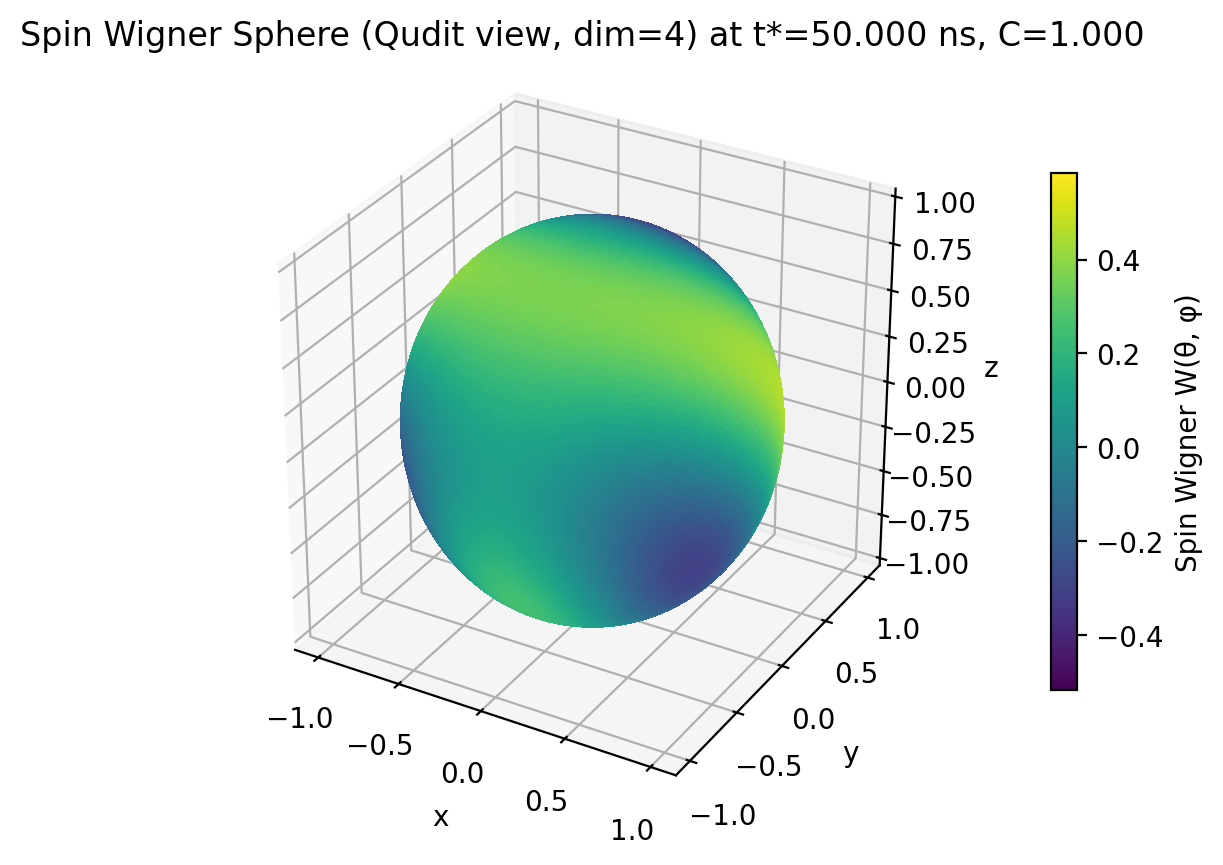

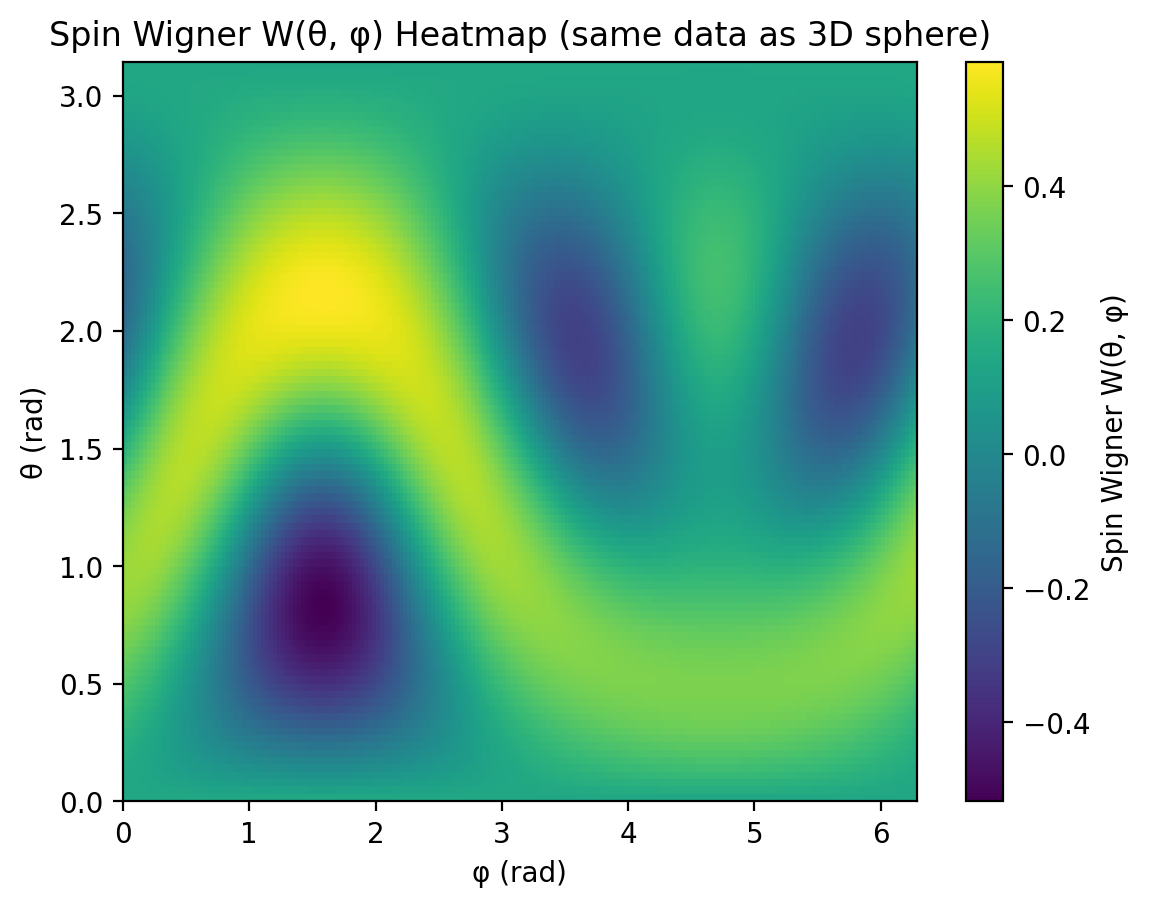

In [8]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import qutip as qt

# Robust import across QuTiP 4.x and 5.x:
# - In QuTiP 5.0.x, spin_wigner is in qutip.wigner, not necessarily in qutip.visualization.
# - In QuTiP 5.2.x, spin_wigner is also defined in qutip.wigner.
try:
    from qutip.wigner import spin_wigner
except ImportError as exc:  # pragma: no cover
    # Some builds may re-export from the top-level namespace.
    try:
        from qutip import spin_wigner  # type: ignore
    except ImportError as exc2:  # pragma: no cover
        raise ImportError(
            "Could not import spin_wigner from either qutip.wigner or qutip. "
            "If you are pinned to an unusual QuTiP build, upgrade with:\n"
            "    !pip install --upgrade qutip\n"
        ) from exc2


def as_qudit_density_matrix(rho: qt.Qobj) -> qt.Qobj:
    """
    Rewrap a two-qubit density matrix as a single 4D qudit density matrix.

    This is done to obtain a single spin-Wigner sphere representation
    (dimension 4 -> spin j=3/2).

    Args:
        rho: Two-qubit density matrix with dims [[2, 2], [2, 2]].

    Returns:
        Density matrix with dims [[4], [4]].
    """
    return qt.Qobj(rho.full(), dims=[[4], [4]])


rho_qudit = as_qudit_density_matrix(rho_star)

theta = np.linspace(0.0, np.pi, KNOBS.wigner_theta_points)
phi = np.linspace(0.0, 2.0 * np.pi, KNOBS.wigner_phi_points)

# QuTiP returns:
#   W, THETA, PHI where THETA, PHI are 2D grids from meshgrid(theta, phi).
w, theta_grid, phi_grid = spin_wigner(rho_qudit, theta, phi)

# Ensure real-valued numpy array for plotting (QuTiP returns W.real already).
w = np.asarray(w, dtype=float)

# Convert sphere coordinates for 3D plotting.
x = np.sin(theta_grid) * np.cos(phi_grid)
y = np.sin(theta_grid) * np.sin(phi_grid)
z = np.cos(theta_grid)

# Shared normalization for consistent color meaning across plots.
w_min = float(np.min(w))
w_max = float(np.max(w))
if np.isclose(w_min, w_max):
    # Avoid singular normalization if the distribution is numerically flat.
    w_min -= 1.0
    w_max += 1.0
norm = Normalize(vmin=w_min, vmax=w_max)

# Matplotlib colormap handling (avoid deprecated cm.get_cmap where possible).
try:
    cmap = plt.colormaps.get_cmap(KNOBS.colormap_name)
except AttributeError:  # pragma: no cover
    import matplotlib.cm as cm

    cmap = cm.get_cmap(KNOBS.colormap_name)

colors = cmap(norm(w))

# 3D colored sphere surface with labeled colorbar (heat-map-like color encoding).
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(
    x,
    y,
    z,
    facecolors=colors,
    rstride=1,
    cstride=1,
    linewidth=0,
    antialiased=False,
    shade=False,
)
ax.set_title(
    "Spin Wigner Sphere (Qudit view, dim=4) "
    f"at t*={t_star_ns:.3f} ns, C={c_star:.3f}"
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_box_aspect((1.0, 1.0, 1.0))

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(w)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.1)
cbar.set_label("Spin Wigner W(θ, φ)")
plt.show()

# 2D heatmap (θ, φ) with labeled gradient.
# IMPORTANT: QuTiP uses THETA, PHI = meshgrid(theta, phi),
# so w has shape (len(phi), len(theta)) and corresponds to w[phi_index, theta_index].
# To plot x=phi and y=theta in the conventional way, transpose w.
fig, ax = plt.subplots()
im = ax.imshow(
    w.T,
    origin="lower",
    aspect="auto",
    extent=[phi[0], phi[-1], theta[0], theta[-1]],
    cmap=cmap,
    vmin=w_min,
    vmax=w_max,
)
ax.set_xlabel("φ (rad)")
ax.set_ylabel("θ (rad)")
ax.set_title("Spin Wigner W(θ, φ) Heatmap (same data as 3D sphere)")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Spin Wigner W(θ, φ)")
plt.show()